In [11]:
from openai import OpenAI
import re

client = OpenAI(
    api_key = "c8a7e43e-cce1-4d61-af75-de350b7e5731",
    base_url = "https://ark.cn-beijing.volces.com/api/v3",
)

In [12]:
import argparse
import pdb

from builder import build
from util import DEFAULTS

In [13]:
print("----- standard request -----")
completion = client.chat.completions.create(
    model = "deepseek-r1-250120",  # your model endpoint ID
    messages = [
        {
            "role": "user", 
            "content": "1+1=?"
        },
    ],
)

----- standard request -----


PermissionDeniedError: Error code: 403 - {'error': {'code': 'AccountOverdueError', 'message': 'The request failed because your account has an overdue balance. Request id: 021742364973444ae3896fadf431819d71188208c4cbf6a293b5a', 'param': '', 'type': 'Forbidden'}}

In [ ]:
print("----- Reasoning content -----")
print(completion.choices[0].message.reasoning_content)

In [37]:
#print("----- Content -----")
#print(completion.choices[0].message.content)

In [1]:
filename = '..\grammar_example.txt'
with open(filename) as file:
        grammer_example = [line for line in file]
grammer_example = ''.join(grammer_example)

In [2]:
quest = '根据文档中的GMBL的语法和示例，使用GMBL语法，生成如下几何图的代码。A circle with center O passes through the vertices A and C of triangle ABC and intersects the segments AB and BC again at distinct points K and N respectively. The circumscribed circles of the triangles ABC and EBN intersect at exactly two distinct points B and M. Prove that angle angle OMB is a right angle.请确保每个点在使用前都已经定义过，确保符合示例的GMBL语法，确保每一句语句都写在同一行，确保GMBL输入的角度是弧度制，确保没有形如(define XXX number xxx)的语句，确保语句中没有使用and或者or。把最终回答放在代码block内。'

In [3]:
messages = [{
    "role": "user", 
    "content": grammer_example + '\n\n' + quest
    }]

In [14]:
input_captions = ['pr1.', 'pr2.']

filename = '..\grammar_example.txt'
with open(filename) as file:
        grammer_example = [line for line in file]
grammer_example = ''.join(grammer_example)

quest1 = '根据文档中的GMBL的语法和示例，使用GMBL语法，生成如下几何图的代码。'
quest2 = '请确保每个点在使用前都已经定义过，确保符合示例的GMBL语法，确保每一句语句都写在同一行，确保GMBL输入的角度是弧度制，确保没有形如(define XXX number xxx)的语句，确保语句中没有使用and或者or。把最终回答放在代码block内。'

messages_list = [
        [{
    "role": "user", 
    "content": grammer_example + '\n\n' + quest1 + input_caption + quest2
    }] 
    for input_caption in input_captions]

In [41]:
response = client.chat.completions.create(
    # 替换 <Model> 为模型的Model ID
    model="deepseek-r1-250120",
    messages=messages,
    stream=True,
)
reasoning_content = ""
content = ""

for chunk in response:
    if hasattr(chunk.choices[0].delta, 'reasoning_content') and chunk.choices[0].delta.reasoning_content:
        reasoning_content += chunk.choices[0].delta.reasoning_content
        print(chunk.choices[0].delta.reasoning_content, end="")
    else:
        content += chunk.choices[0].delta.content
        print(chunk.choices[0].delta.content, end="")

嗯，用户让我用GMBL语法生成一个几何题的代码。题目是说，圆O以三角形ABC的顶点A和C为中心，通过这两个点，然后与AB和BC再次交于不同的点K和N。三角形ABC和EBN的外接圆在B和M两点相交，证明角OMB是直角。我得先把这个几何结构用GMBL的语法表达出来，确保每个点在使用前都定义好了，还要符合语法规则。

首先，我需要确定如何参数化各个点。可能需要先用param定义三角形ABC，比如(param (A B C) triangle)。然后定义圆O，因为圆O经过A和C，所以可以用circumcircle吗？或者用circ函数？circumcircle是外接圆，但题目中的圆O可能不是ABC的外接圆，而是以O为中心经过A和C，所以可能需要用coa函数，比如(coa O A)，然后O是中心，但需要确定如何定义O的位置。或者可能需要用param来定义O，但题目中O是圆心，所以可能需要通过其他点来定义。

或者，题目说圆O经过A和C，所以应该用circumcircle的话可能需要三个点，但这里可能O是中心，所以可能用coa，即圆心为O，经过A，这样另一个点C也需要在圆上，可能需要assert一下OC等于OA，因为半径相同。或者直接用circ函数，比如(define O point ...)，但可能需要更多的步骤。

不过可能更简单的是，先定义三角形ABC，然后定义圆O为经过A和C的圆，同时圆心是O。这时候可能需要用circ函数，但circ需要三个点，但如果圆心是O，那可能需要不同的方法。或者，题目中的圆O可能以O为中心，经过A和C，所以可以用coa定义，比如(coa O A)，然后C也在圆O上，这可能需要在assert中声明(on-circ C (coa O A))？或者直接定义圆O为经过A和C，并确定O为中心。这可能比较复杂。

或者，考虑用param来定义圆O。例如，param O point，然后定义圆O为以O为中心，经过A，即(define Gamma circle (coa O A))，然后assert(on-circ C Gamma)。这样就能保证C在圆O上。

接下来，圆O与AB和BC再次交于K和N。所以需要找到AB线段上的交点，比如K是AB上的另一个交点，N是BC上的另一个交点。这时候需要用到inter-lc函数，参数是直线AB和圆Gamma，并且使用roo

In [42]:
print(content)
content



```lisp
(param (A B C) triangle)
(param O point)
(define Gamma circle (coa O A))
(assert (on-circ C Gamma))
(define K point (inter-lc (line A B) Gamma (rs-neq A)))
(assert (on-seg K A B))
(define N point (inter-lc (line B C) Gamma (rs-neq C)))
(assert (on-seg N B C))
(define circ1 circle (circumcircle A B C))
(define circ2 circle (circumcircle K B N))
(define M point (inter-cc circ1 circ2 (rs-neq B)))
(eval (perp (line O M) (line M B)))
```


'\n\n```lisp\n(param (A B C) triangle)\n(param O point)\n(define Gamma circle (coa O A))\n(assert (on-circ C Gamma))\n(define K point (inter-lc (line A B) Gamma (rs-neq A)))\n(assert (on-seg K A B))\n(define N point (inter-lc (line B C) Gamma (rs-neq C)))\n(assert (on-seg N B C))\n(define circ1 circle (circumcircle A B C))\n(define circ2 circle (circumcircle K B N))\n(define M point (inter-cc circ1 circ2 (rs-neq B)))\n(eval (perp (line O M) (line M B)))\n```'

In [64]:
try:
    re_find = re.finditer('```', content)
    inds = []
    for ind in re_find:
        inds += [ind.span()]

    lines = content[inds[0][1] : inds[1][0]]
    lines = lines.splitlines()[1:]

    print(lines)
except:
    try:
        re_find = re.finditer('```', reasoning_content)
        inds = []
        for ind in re_find:
            inds += [ind.span()]

        lines = content[inds[0][1] : inds[1][0]]
        lines = lines.splitlines()[1:]

        print(lines)
    except:
        raise RuntimeError("No code block found in the reasoning content or content")

['(param (A B C) triangle)', '(param O point)', '(define Gamma circle (coa O A))', '(assert (on-circ C Gamma))', '(define K point (inter-lc (line A B) Gamma (rs-neq A)))', '(assert (on-seg K A B))', '(define N point (inter-lc (line B C) Gamma (rs-neq C)))', '(assert (on-seg N B C))', '(define circ1 circle (circumcircle A B C))', '(define circ2 circle (circumcircle K B N))', '(define M point (inter-cc circ1 circ2 (rs-neq B)))', '(eval (perp (line O M) (line M B)))']


In [44]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def')


args = parser.parse_args()
args = vars(args)

In [49]:
args['n_tries'] = 10
args['eps'] = 1e-4
args['n_iterations'] = 10000

args['lines'] = lines
lines

['(param (A B C) triangle)',
 '(param O point)',
 '(define Gamma circle (coa O A))',
 '(assert (on-circ C Gamma))',
 '(define K point (inter-lc (line A B) Gamma (rs-neq A)))',
 '(assert (on-seg K A B))',
 '(define N point (inter-lc (line B C) Gamma (rs-neq C)))',
 '(assert (on-seg N B C))',
 '(define circ1 circle (circumcircle A B C))',
 '(define circ2 circle (circumcircle K B N))',
 '(define M point (inter-cc circ1 circ2 (rs-neq B)))',
 '(eval (perp (line O M) (line M B)))']

Processing instructions...:   8%|▊         | 1/12 [00:00<00:01,  5.86it/s]

INPUT INSTRUCTIONS:
sample (A B C) triangle ()
parameterize O coords
define Gamma ((coa O A))
assert (on-circ C Gamma)
define K ((inter-lc (connecting A B) Gamma (root-neq A)))
assert (on-seg K A B)
define N ((inter-lc (connecting B C) Gamma (root-neq C)))
assert (on-seg N B C)
define circ1 ((circumcircle A B C))
define circ2 ((circumcircle K B N))
define M ((inter-cc circ1 circ2 (root-neq B)))
eval (perp (connecting O M) (connecting M B))


Sampling initializations...: 100%|██████████| 10/10 [01:49<00:00, 10.94s/it]


[     0]   0.116844542460 ||   0.100000
======== Print losses ==========
-- Losses --
  on-circ_C_Gamma                                    0.1076437840
  interLC_K                                          0.0000000000
  on-seg_K_A_B_0                                     0.0000000000
  on-seg_K_A_B_1                                     0.0000000000
  on-seg_K_A_B_2                                     0.0000000000
  interLC_N                                          0.0000000000
  on-seg_N_B_C_0                                     0.0000000000
  on-seg_N_B_C_1                                     0.0091931023
  on-seg_N_B_C_2                                     0.0000034804
  interLC_M                                          0.0000000000
  points                                             0.0000022574
  distinct                                           0.0000019183
-- Goals --
  perp_(connecting O M)_(connecting M B)             0.0777487398
-- NDGs --


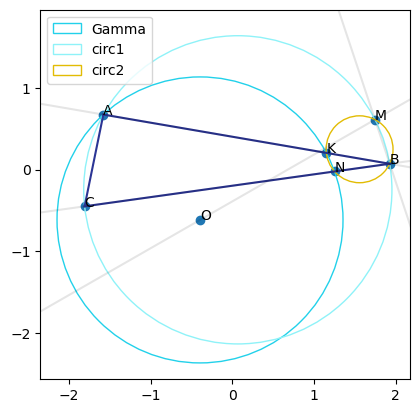

======== Print losses ==========
-- Losses --
  on-circ_C_Gamma                                    0.0000230273
  interLC_K                                          0.0000000000
  on-seg_K_A_B_0                                     0.0000000000
  on-seg_K_A_B_1                                     0.0000000000
  on-seg_K_A_B_2                                     0.0000000000
  interLC_N                                          0.0000000000
  on-seg_N_B_C_0                                     0.0000000000
  on-seg_N_B_C_1                                     0.0000000000
  on-seg_N_B_C_2                                     0.0000000000
  interLC_M                                          0.0000000000
  points                                             0.0000016614
  distinct                                           0.0000000011
-- Goals --
  perp_(connecting O M)_(connecting M B)             0.0000547841
-- NDGs --


Found 1 models


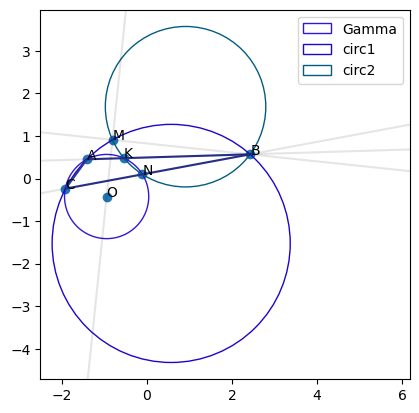

In [65]:
res = build(args)

In [80]:
for item in res[0]:
    print(item)
print('')

print('######################## named_points ########################')
for obj_name, obj in res[1][0].named_points.items():
    print(obj_name)
    print(obj)
    (x, y) = obj
print('')


print('######################## named_lines ########################')
for obj_name, obj in res[1][0].named_lines.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj
    # slope = y/x, intercept = r
print('')


print('######################## named_circles ########################')
for obj_name, obj in res[1][0].named_circles.items():
    print(obj_name)
    print(obj)
    (x, y), r = obj
print('')

print('######################## segments ########################')
for obj in res[1][0][3]:
    print(obj)
print('')

print('######################## seg_colors ########################')
for obj in res[1][0][4]:
    print(obj)
print('')

print('######################## unnamed_points ########################')
for obj in res[1][0][5]:
    print(obj)
print('')

print('######################## unnamed_lines ########################')
for obj in res[1][0][6]:
    print(obj)
print('')

print('######################## unnamed_circles ########################')
for obj in res[1][0][7]:
    print(obj)
print('')

print('######################## ndgs (negative assertions) ########################')
for obj_name, obj in res[1][0].ndgs.items():
    print(obj_name)
    print(obj)
print('')

print('######################## goals ########################')
for obj_name, obj in res[1][0].goals.items():
    print(obj_name)
    print(obj)
print('')

(param (A B C) triangle)
(param O point)
(define Gamma circle (coa O A))
(assert (on-circ C Gamma))
(define K point (inter-lc (line A B) Gamma (rs-neq A)))
(assert (on-seg K A B))
(define N point (inter-lc (line B C) Gamma (rs-neq C)))
(assert (on-seg N B C))
(define circ1 circle (circumcircle A B C))
(define circ2 circle (circumcircle K B N))
(define M point (inter-cc circ1 circ2 (rs-neq B)))
(eval (perp (line O M) (line M B)))

######################## named_points ########################
A
(coords -1.410823 0.451493)
B
(coords 2.424409 0.568514)
C
(coords -1.915197 -0.238256)
O
(coords -0.947944 -0.423137)
K
(coords -0.539250 0.478087)
N
(coords -0.106699 0.097959)
M
(coords -0.810046 0.908911)

######################## named_lines ########################

######################## named_circles ########################
Gamma
CircleNF(center=TfPoint(x=-0.9479441607502552, y=-0.4231365786730189), radius=0.9895626136931899)
circ1
CircleNF(center=TfPoint(x=0.5688984141775706, y=-1.525

In [53]:
import pickle

with open('../llm_gen/res_test.pkl', 'rb') as f:
    result_dict = pickle.load(f)

for res in result_dict.items():
    print(res[1][1].choices[0].message.content)



```GMBL
(param (A B C) (right-tri A))
(assert (cong A B A C))
```


```lisp
(param (A B C D) parallelogram)
(assert (cong A B B C))
```


In [111]:
import json

cnt = 0
with open("C:\qinshenghao\桌面\geometry3k_v2_14k_20240103.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        # for key, value in data.items():
        #     print([key, value])
        print(data['conversations'][0]['value'])
        # content = data['conversations'][1]['value']

        # inds = []
        # re_find = re.finditer('Information in the Image', content)
        # for ind in re_find:
        #     inds += [ind.span()]
        # re_find = re.finditer('Terms and Knowledge Points', content)
        # for ind in re_find:
        #     inds += [ind.span()]


        # lines = content[inds[0][1] : inds[1][0]]
        # lines = ''.join(lines.splitlines()[1:-2])

        # print(lines)

        cnt += 1
        if cnt == 10:
            break

<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the nearest hundredth, if necessary.
A. 4
B. 8
C. 16
D. 32
<image>
Find the area of the figure. Round to the neare

In [13]:
import json

cnt = -1
input_captions = []
with open("C:\qinshenghao\桌面\geoqa_v2_99k_20250103.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        cnt += 1
        data = json.loads(line)
        if cnt == 200:
            break
        if cnt % 20 != 0:
            continue

        content = data['conversations'][1]['value']
        #print(data['conversations'][0]['value'])
        #print(data['conversations'][1]['value'])
        # inds = []
        # re_find = re.finditer('Information in the Image', content)
        # for ind in re_find:
        #     inds += [ind.span()]
        # re_find = re.finditer('Terms and Knowledge Points', content)
        # for ind in re_find:
        #     inds += [ind.span()]

        # inds = []
        # re_find = re.finditer('<image>\n', content)
        # for ind in re_find:
        #     inds += [ind.span()]
        # re_find = re.finditer('\nA', content)
        # for ind in re_find:
        #     inds += [ind.span()]

        
        inds = []
        re_find = re.finditer('## 列出已知信息', content)
        for ind in re_find:
            inds += [ind.span()]
        re_find = re.finditer('## 术语与知识点', content)
        for ind in re_find:
            inds += [ind.span()]

        lines = content[inds[0][1] : inds[1][0]]
        lines = ''.join(lines.splitlines()[:-1])
        lines = ''.join(['\n', lines, '\n'])

        input_captions += [lines]

#input_captions = ['等腰直角三角形ABC，其中A为直角。', '菱形ABCD。']
for item in input_captions:
    print(item)


### 问题文本中的信息1. 图形中bc为半圆的直径。2. D和E是bc上的两个点。3. 连接bd和ce，并延伸交于点a。4. 连接od和oe。5. ∠a的度数为70°。### 图片中的信息1. 半圆的直径bc，直线bc被两点o分成bo和oc两段，o为中央点。2. 点d和点e位于半圆直径的两侧。3. 点a位于半圆外，bd与ce交于点a。4. 点d和点o相连成od。5. 点e和点o相连成oe。6. ∠a标注为70°。7. 通过图形的几何对称性和已知直径的性质，bd和ce将构成一些补角和对角关系，待进一步证明。


### 问题文本中的信息1. AB = 42. BC = 53. AC的垂直平分线交AD于点E### 图片中的信息图片显示一个平行四边形ABCD，且有以下特征：1. 点A, B, C, D按顺时针方向依次排列。2. AB为底边，长度为4。3. BC为侧边，长度为5。4. 线段AC被垂直平分，且中垂线与AD交于点E。图片还给我们一些几何关系的提示：1. E是AC的中垂线上一点，所以AE=EC。2. AC的中垂线意味着BE=DE，这是一个几何性质，并且DE垂直于AC。


回顾你的推理，并识别出问题和图片中可能对解决问题有用的信息。### 问题文本中的信息已知：1. 点C是线段AB的中点。2. 点D是线段BC的中点。3. AB = 20cm。### 图片中的信息图片展示了一条水平线段AB，并标注了三个点A、C、D和B。具体描述如下：1. 点A标在最左端。2. 点B标在最右端。3. 点C位于AB的中点，线段AC与CB相等。4. 点D位于BC的中点，线段BD与DC相等。


### 问题文本中的信息1. AB和Cd是平行线，即AB‖Cd。2. 点E和F处的EF线分别垂直AB和Cd，即EF⊥AB，EF⊥Cd。3. 点M位于直线EM上且∠EM与线Cd有一定关系。4. ∠1的角度给出为55°。### 图片中的信息1. 图中存在四条线：AB，Cd，EF和EM。2. AB和Cd为平行线，AB在线底部，Cd在线顶部。3. EF线形状笔直，垂直于与AB，Cd的交点为F和E。E点EF⊥AB，F点EF⊥Cd均为直角。4. 点M位于Cd上，且在左侧。5. ∠1标注在Cd与EM的交点M处，角度大小标识为55°。6. ∠2标注在E点处，是EF与EM夹角处。


### 问题文本中的信息1

In [ ]:
import argparse
import pdb
from builder import build
from util import DEFAULTS
import pickle
import re


def gmb_draw(inputs):
    content, reasoning_content, input_caption = inputs
    try:
        re_find = re.finditer('```', content)
        inds = []
        for ind in re_find:
            inds += [ind.span()]

        lines = content[inds[0][1] : inds[1][0]]
        lines = lines.splitlines()[1:]

        print(lines)
    except:
        try:
            re_find = re.finditer('```', reasoning_content)
            inds = []
            for ind in re_find:
                inds += [ind.span()]

            lines = reasoning_content[inds[0][1] : inds[1][0]]
            lines = lines.splitlines()[1:]

            print(lines)
        except:
            raise RuntimeError("No code block found in the reasoning content or content")
        
    args['lines'] = lines

    try:
        res = build(args)
    except:
        res = [lines, [None]]

    try:
        if res[1] != [] and res[1][0] is not None:
            segments_list = get_segments(content, reasoning_content)
            dict_points = {ps.val: ps for ps in res[1][0].named_points}
            for seg in segments_list:
                ps_seg = tuple([res[1][0].named_points[dict_points[ps]] for ps in seg])
                res[1][0].segments.append(ps_seg)
                res[1][0].seg_colors.append([0, 0, 0])
        else:
            pass
    except:
        print("Fail to add additional segments!!!")

    return res + [input_caption]


def get_segments(content, reasoning_content):
    try:
        re_find = re.finditer('```', content)
        inds = []
        for ind in re_find:
            inds += [ind.span()]

        re_find = re.finditer(';; segments to connect: ', content)
        inds_seg = []
        for ind in re_find:
            inds_seg += [ind.span()]

        lines = content[inds_seg[0][1] : inds[1][0]]
        lines = lines.upper().splitlines()[0].split(' ')
    except:
        try:
            re_find = re.finditer('```', reasoning_content)
            inds = []
            for ind in re_find:
                inds += [ind.span()]

            re_find = re.finditer(';; segments to connect: ', reasoning_content)
            inds_seg = []
            for ind in re_find:
                inds_seg += [ind.span()]

            lines = reasoning_content[inds_seg[0][1] : inds[1][0]]
            lines = lines.upper().splitlines()[0].split(' ')
        except:
            raise RuntimeError("No segment list found in the reasoning content or content")
    
    if lines is None or lines == []:
        return []

    segments_list = []
    for segment in lines:
        try:
            assert(len(segment) == 2)
            segments_list += [[segment[0], segment[1]]]
        except:
            print("Fail to get segment " + segment + " !!!")
    
    return segments_list

Processing instructions...:   0%|          | 0/6 [00:00<?, ?it/s]

Processing instructions...:  50%|█████     | 3/6 [00:00<00:00, 24.84it/s]

['(param A point)', '(param B point)', '(assert (= (dist A B) 20))', '(define C point (midp A B))', '(define D point (midp B C))', ';; segments to connect: AB']
INPUT INSTRUCTIONS:
parameterize A coords
parameterize B coords
assert (eq-n (dist A B) 20.0)
define C ((midp A B))
define D ((midp B C))
sample (G H I) triangle ()


Sampling initializations...: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


[     0] 351.758246422647 ||   0.100000
======== Print losses ==========
-- Losses --
  eq-n_(dist A B)_20.0                               351.7582464226
  points                                             0.0000009259
  distinct                                           0.0000002164
-- Goals --
-- NDGs --


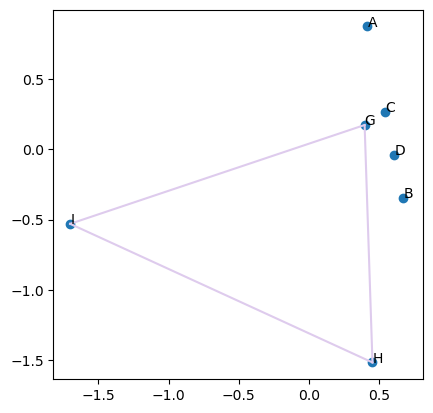

[     1] 342.639128413751 ||   0.099964
[     2] 333.251452973781 ||   0.099929
[     3] 323.753945836955 ||   0.099893
[     4] 314.234255622640 ||   0.099857
[     5] 304.746500706915 ||   0.099822
[     6] 295.326757836379 ||   0.099786
[     7] 286.000511956244 ||   0.099751
[     8] 276.786684691835 ||   0.099715
[     9] 267.699807304067 ||   0.099680
[    10] 258.751325075696 ||   0.099644
[    11] 249.950487212118 ||   0.099608
[    12] 241.304856765023 ||   0.099573
[    13] 232.820657780930 ||   0.099537
[    14] 224.503071850638 ||   0.099502
[    15] 216.356380397572 ||   0.099466
[    16] 208.384134472857 ||   0.099431
[    17] 200.589220462760 ||   0.099395
[    18] 192.973967590572 ||   0.099360
[    19] 185.540183100494 ||   0.099325
[    20] 178.289223622582 ||   0.099289
[    21] 171.222012638332 ||   0.099254
[    22] 164.339098351626 ||   0.099218
[    23] 157.640659477812 ||   0.099183
[    24] 151.126552258704 ||   0.099148
[    25] 144.796314266653 ||   0.099112


In [61]:
import pickle

with open('../llm_gen/res_llm_gen20250311143434.pkl', 'rb') as f:
    llm_result_dict = pickle.load(f)
all_contents_and_reasoning= [[res[1][1].choices[0].message.content, res[1][1].choices[0].message.reasoning_content, res[1][2]] for res in llm_result_dict.items()]

# for item in all_contents_and_reasoning:
#     content = item[0]
#     reasoning_content = item[1]
#     print(item[0])

#     res = gmb_draw(item)
#     print(res[2])
#     if res[1] == []:
#         print('Fail to solve!!!')
#     elif res[1][0] is None:
#         print('GMBL grammar error!!!')
#     else:
#         res[1][0].plot()
#         print(res[1][0])
#     print('')

#     break

content = all_contents_and_reasoning[2][0]
reasoning_content = all_contents_and_reasoning[2][1]
res = gmb_draw(all_contents_and_reasoning[2])



```gmb
(param A point)
(param B point)
(assert (= (dist A B) 20))
(define C point (midp A B))
(define D point (midp B C))
;; segments to connect: AB
```
[['A', 'B']]
(TfPoint(x=-6.995085043620456, y=6.8316516410083565), TfPoint(x=8.083051278232226, y=-6.300344798984476))


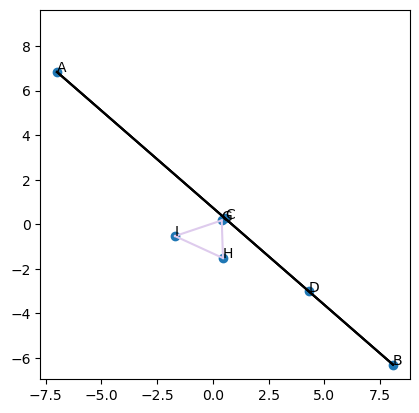

In [64]:
import re

print(content)

def get_segments(content, reasoning_content):
    try:
        re_find = re.finditer('```', content)
        inds = []
        for ind in re_find:
            inds += [ind.span()]

        re_find = re.finditer(';; segments to connect: ', content)
        inds_seg = []
        for ind in re_find:
            inds_seg += [ind.span()]

        lines = content[inds_seg[0][1] : inds[1][0]]
        lines = lines.upper().splitlines()[0].split(' ')
    except:
        try:
            re_find = re.finditer('```', reasoning_content)
            inds = []
            for ind in re_find:
                inds += [ind.span()]

            re_find = re.finditer(';; segments to connect: ', reasoning_content)
            inds_seg = []
            for ind in re_find:
                inds_seg += [ind.span()]

            lines = reasoning_content[inds_seg[0][1] : inds[1][0]]
            lines = lines.upper().splitlines()[0].split(' ')
        except:
            raise RuntimeError("No segment list found in the reasoning content or content")
    
    segments_list = []
    for segment in lines:
        try:
            segments_list += [[segment[0], segment[1]]]
        except:
            print("Fail to get segment " + segment + " !!!")
    
    return segments_list

segments_list = get_segments(content, reasoning_content)
print(segments_list)

if res[1] != [] and res[1][0] is not None:
    segments_list = get_segments(content, reasoning_content)

dict_points = {ps.val: ps for ps in res[1][0].named_points}
for seg in segments_list:
    ps_seg = tuple([res[1][0].named_points[dict_points[ps]] for ps in seg])
    res[1][0].segments.append(ps_seg)
    res[1][0].seg_colors.append([0, 0, 0])

print(ps_seg)

res[1][0].plot()


### 问题文本中的信息1. 图形中bc为半圆的直径。2. D和E是bc上的两个点。3. 连接bd和ce，并延伸交于点a。4. 连接od和oe。5. ∠a的度数为70°。### 图片中的信息1. 半圆的直径bc，直线bc被两点o分成bo和oc两段，o为中央点。2. 点d和点e位于半圆直径的两侧。3. 点a位于半圆外，bd与ce交于点a。4. 点d和点o相连成od。5. 点e和点o相连成oe。6. ∠a标注为70°。7. 通过图形的几何对称性和已知直径的性质，bd和ce将构成一些补角和对角关系，待进一步证明。

['(param B point)', '(param C point)', '(define O point (midp B C))', '(param D point (on-seg B O))', '(param E point (on-seg O C))', '(define BD line (line B D))', '(define CE line (line C E))', '(define A point (inter-ll BD CE))', '(eval (= (uangle B A C) (mul pi (div 70 180))))']


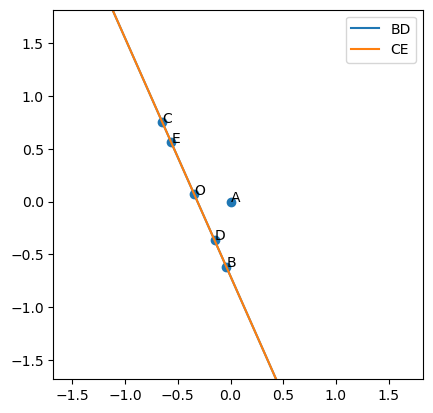

Diagram(named_points={<primitives.Point object at 0x000002B8513480A0>: TfPoint(x=-0.040536049797046836, y=-0.6166775114234837), <primitives.Point object at 0x000002B8500FA340>: TfPoint(x=-0.6458843875721225, y=0.7502341920325732), <primitives.Point object at 0x000002B8501AF370>: TfPoint(x=-0.3432102186845847, y=0.06677834030454477), <primitives.Point object at 0x000002B850211970>: TfPoint(x=-0.15140545333355024, y=-0.3663279592858704), <primitives.Point object at 0x000002B850211730>: TfPoint(x=-0.5621672238811986, y=0.5611959743844235), <primitives.Point object at 0x000002B8513D3F70>: TfPoint(x=-5.551115123125783e-13, y=5.551115123125783e-13)}, named_lines={<primitives.Line object at 0x000002B8513D36A0>: LineNF(n=TfPoint(x=0.9143489621207289, y=0.4049271236515846), r=-0.28677354598173244), <primitives.Line object at 0x000002B8513D3100>: LineNF(n=TfPoint(x=0.914348962120729, y=0.4049271236515846), r=-0.2867735459817325)}, named_circles={}, segments=[], seg_colors=[], unnamed_points=[], 

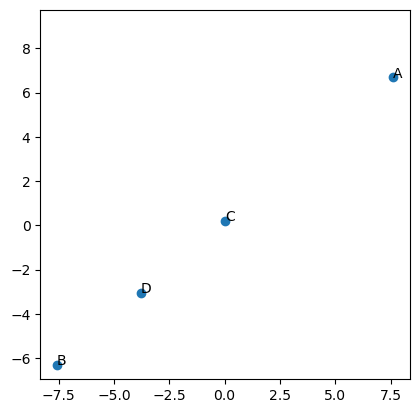

Diagram(named_points={<primitives.Point object at 0x000002B84F88DFA0>: TfPoint(x=7.612417872352257, y=6.693367112673269), <primitives.Point object at 0x000002B85020AF70>: TfPoint(x=-7.580488597113304, y=-6.311172315042805), <primitives.Point object at 0x000002B85020AEE0>: TfPoint(x=0.01596463761947664, y=0.19109739881523202), <primitives.Point object at 0x000002B85020ADF0>: TfPoint(x=-3.7822619797469135, y=-3.0600374581137864)}, named_lines={}, named_circles={}, segments=[], seg_colors=[], unnamed_points=[], unnamed_lines=[], unnamed_circles=[], ndgs={}, goals={})


### 问题文本中的信息1. AB和Cd是平行线，即AB‖Cd。2. 点E和F处的EF线分别垂直AB和Cd，即EF⊥AB，EF⊥Cd。3. 点M位于直线EM上且∠EM与线Cd有一定关系。4. ∠1的角度给出为55°。### 图片中的信息1. 图中存在四条线：AB，Cd，EF和EM。2. AB和Cd为平行线，AB在线底部，Cd在线顶部。3. EF线形状笔直，垂直于与AB，Cd的交点为F和E。E点EF⊥AB，F点EF⊥Cd均为直角。4. 点M位于Cd上，且在左侧。5. ∠1标注在Cd与EM的交点M处，角度大小标识为55°。6. ∠2标注在E点处，是EF与EM夹角处。

['(param A point)', '(param B point)', '(define AB line (line A B))', '(param C point)', '(param D point)', '(define Cd line (line C D))', '(

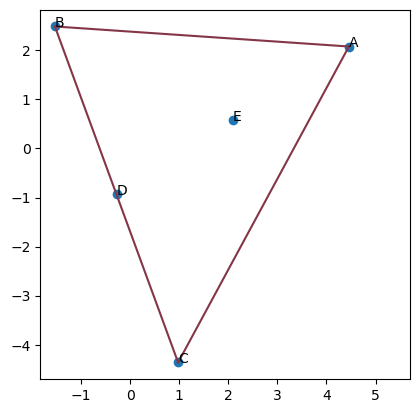

Diagram(named_points={<primitives.Point object at 0x000002B85020A910>: TfPoint(x=4.456656140721844, y=2.077277477300859), <primitives.Point object at 0x000002B85020A760>: TfPoint(x=-1.5346717242719996, y=2.485713134163038), <primitives.Point object at 0x000002B85020AA00>: TfPoint(x=0.9761401022314252, y=-4.362372002207828), <primitives.Point object at 0x000002B85020A9A0>: TfPoint(x=-0.2792658110202872, y=-0.9383294340223951), <primitives.Point object at 0x000002B85020A4C0>: TfPoint(x=2.0886951648507783, y=0.5694740216392319)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=4.456656140721844, y=2.077277477300859), TfPoint(x=-1.5346717242719996, y=2.485713134163038)), (TfPoint(x=-1.5346717242719996, y=2.485713134163038), TfPoint(x=0.9761401022314252, y=-4.362372002207828)), (TfPoint(x=0.9761401022314252, y=-4.362372002207828), TfPoint(x=4.456656140721844, y=2.077277477300859))], seg_colors=[array([0.51957651, 0.21082618, 0.27905169]), array([0.51957651, 0.21082618, 0.27905169]), 

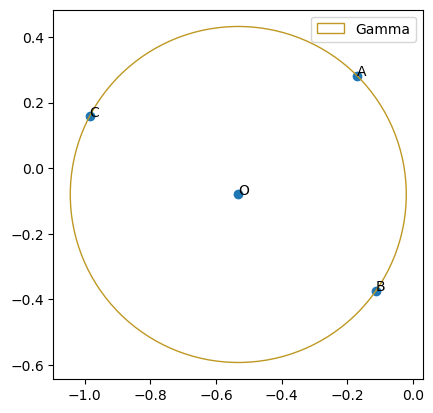

Diagram(named_points={<primitives.Point object at 0x000002B85020A700>: TfPoint(x=-0.5319475718246286, y=-0.08043185913263587), <primitives.Point object at 0x000002B85020A730>: TfPoint(x=-0.1700215725462219, y=0.28225840351822507), <primitives.Point object at 0x000002B85020A400>: TfPoint(x=-0.1118040570582104, y=-0.373713434713415), <primitives.Point object at 0x000002B85020A460>: TfPoint(x=-0.9855662968906522, y=0.15782159382219335)}, named_lines={}, named_circles={<primitives.Circle object at 0x000002B85020A0A0>: CircleNF(center=TfPoint(x=-0.5319475718246286, y=-0.08043185913263587), radius=0.5123813575603856)}, segments=[], seg_colors=[], unnamed_points=[], unnamed_lines=[], unnamed_circles=[], ndgs={}, goals={'eq-n_(uangle A C B)_(div (mul 40.0 3.141592653589793) 180.0)': 3.877973036969035e-08})


回顾你的推理，并识别出问题和图片中可能对解决问题有用的信息。### 问题文本中的信息列出问题中提供的已知条件和材料。1. 四边形ABCD内接于圆⊙O。2. 给定∠A=50°。3. 点E在BC的延长线上。### 图片中的信息请详细描述图片中所有已知信息。所有信息需要准确表达，不遗漏任何信息。包括所有可见数据、标签、数值、关系、图表或符号。避免模糊，确保没有图片的人也能完全理解

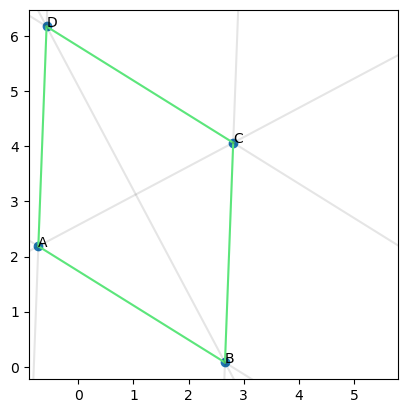

Diagram(named_points={<primitives.Point object at 0x000002B85020A100>: TfPoint(x=-0.7248700924882927, y=2.1863803124041494), <primitives.Point object at 0x000002B85020A130>: TfPoint(x=2.658629211006606, y=0.07878435783238956), <primitives.Point object at 0x000002B8513C2A90>: TfPoint(x=2.8077906990744594, y=4.062263671884708), <primitives.Point object at 0x000002B8513C25B0>: TfPoint(x=-0.5756676300565848, y=6.169993905704842)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-0.7248700924882927, y=2.1863803124041494), TfPoint(x=2.658629211006606, y=0.07878435783238956)), (TfPoint(x=2.658629211006606, y=0.07878435783238956), TfPoint(x=2.8077906990744594, y=4.062263671884708)), (TfPoint(x=2.8077906990744594, y=4.062263671884708), TfPoint(x=-0.5756676300565848, y=6.169993905704842)), (TfPoint(x=-0.5756676300565848, y=6.169993905704842), TfPoint(x=-0.7248700924882927, y=2.1863803124041494))], seg_colors=[array([0.40523478, 0.9985268 , 0.54102934]), array([0.40523478, 0.9985268 , 0.54

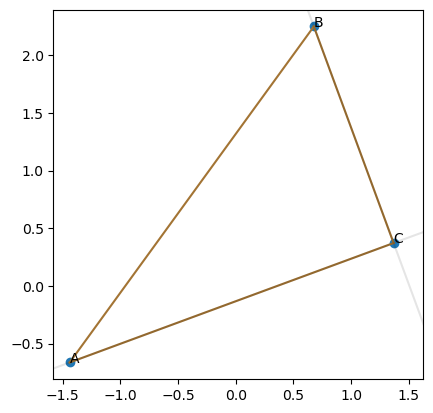

Diagram(named_points={<primitives.Point object at 0x000002B8502169A0>: TfPoint(x=-1.4400458821436066, y=-0.6641018972554287), <primitives.Point object at 0x000002B850216A60>: TfPoint(x=0.6773551651410282, y=2.249729040850417), <primitives.Point object at 0x000002B850216700>: TfPoint(x=1.3692351785735961, y=0.3716862867700851)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-1.4400458821436066, y=-0.6641018972554287), TfPoint(x=0.6773551651410282, y=2.249729040850417)), (TfPoint(x=0.6773551651410282, y=2.249729040850417), TfPoint(x=1.3692351785735961, y=0.3716862867700851)), (TfPoint(x=1.3692351785735961, y=0.3716862867700851), TfPoint(x=-1.4400458821436066, y=-0.6641018972554287))], seg_colors=[array([0.63903296, 0.45648465, 0.20580828]), array([0.63903296, 0.45648465, 0.20580828]), array([0.63903296, 0.45648465, 0.20580828])], unnamed_points=[], unnamed_lines=[LineNF(n=TfPoint(x=-0.3459376334088207, y=0.9382575093179402), r=-0.12493252758332019), LineNF(n=TfPoint(x=0.93834805

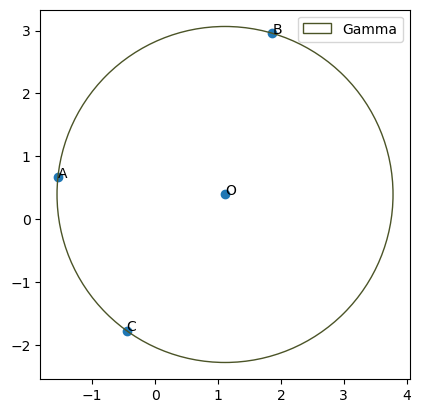

Diagram(named_points={<primitives.Point object at 0x000002B850216580>: TfPoint(x=1.1111041998890823, y=0.394842391854921), <primitives.Point object at 0x000002B850216160>: TfPoint(x=-1.545396753016782, y=0.6663819571181117), <primitives.Point object at 0x000002B850216970>: TfPoint(x=1.863747705938017, y=2.9569233431707564), <primitives.Point object at 0x000002B850216100>: TfPoint(x=-0.4546788162497646, y=-1.7682698555017025)}, named_lines={}, named_circles={<primitives.Circle object at 0x000002B85179FD60>: CircleNF(center=TfPoint(x=1.1111041998890823, y=0.394842391854921), radius=2.670342870923711)}, segments=[], seg_colors=[], unnamed_points=[], unnamed_lines=[], unnamed_circles=[], ndgs={}, goals={})


### 问题文本中的信息1. 圆的圆心为O。2. 点A、B、C是圆上的点。3. 连接了OA、OB、AC和BC这些线段。4. 已知∠CAO=20°。5. 已知∠CBO=50°。### 图片中的信息1. 一个圆，圆心标记为O。2. 点A、B、C在圆上，分别位于不同的位置，A在底部，B在底部偏右，C在顶部。3. 从圆心O连接到了A和B，通过线段OA和OB。4. 从A连接到了C，通过线段AC。5. 从C连接到了B，通过线段CB。6. 在图片中可以看到角度的分布：   - ∠CAO位于A、O、C所形成的角上，角度为20°。   - ∠CBO位于B、O、C所形成的角上，角度为5

In [12]:
import pickle

with open('../llm_gen/res_gmb_draw.pkl', 'rb') as f:
    gmb_result_dict = pickle.load(f)

for key, res in gmb_result_dict.items():
    print(res[2])
    print(res[0])
    if res[1] == []:
        print('Fail to solve!!!')
    elif res[1][0] is None:
        print('GMBL grammar error!!!')
    else:
        res[1][0].plot()
        print(res[1][0])
    
    print('')
    


### 问题文本中的信息1. 图形中bc为半圆的直径。2. D和E是bc上的两个点。3. 连接bd和ce，并延伸交于点a。4. 连接od和oe。5. ∠a的度数为70°。### 图片中的信息1. 半圆的直径bc，直线bc被两点o分成bo和oc两段，o为中央点。2. 点d和点e位于半圆直径的两侧。3. 点a位于半圆外，bd与ce交于点a。4. 点d和点o相连成od。5. 点e和点o相连成oe。6. ∠a标注为70°。7. 通过图形的几何对称性和已知直径的性质，bd和ce将构成一些补角和对角关系，待进一步证明。

['(param B point)', '(param C point)', '(define O point (midp B C))', '(define Gamma circle (diam B C))', '(param D point (on-minor-arc Gamma B C))', '(param E point (on-minor-arc Gamma C B))', '(define A point (inter-ll (line B D) (line C E)))', '(assert (= (uangle B A C) (div (mul 7 pi) 18)))', '', ';; segments to connect: BC BD CE OD OE']


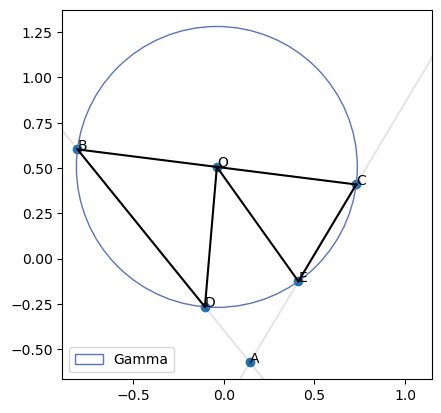

Diagram(named_points={<primitives.Point object at 0x0000022085961E50>: TfPoint(x=-0.8075240269017016, y=0.6029463575948067), <primitives.Point object at 0x0000022085961AC0>: TfPoint(x=0.73019205692321, y=0.4092373653147093), <primitives.Point object at 0x0000022092208DC0>: TfPoint(x=-0.03866598498924578, y=0.506091861454758), <primitives.Point object at 0x0000022092208EB0>: TfPoint(x=-0.10449246093632897, y=-0.2660417779499673), <primitives.Point object at 0x0000022092208F70>: TfPoint(x=0.4111353723111255, y=-0.12494080093819769), <primitives.Point object at 0x00000220922085E0>: TfPoint(x=0.1436554036700772, y=-0.5727670526645297)}, named_lines={}, named_circles={<primitives.Circle object at 0x0000022092208D90>: CircleNF(center=TfPoint(x=-0.03866598498924578, y=0.506091861454758), radius=0.7749345017716003)}, segments=[(TfPoint(x=-0.8075240269017016, y=0.6029463575948067), TfPoint(x=0.73019205692321, y=0.4092373653147093)), (TfPoint(x=-0.8075240269017016, y=0.6029463575948067), TfPoint

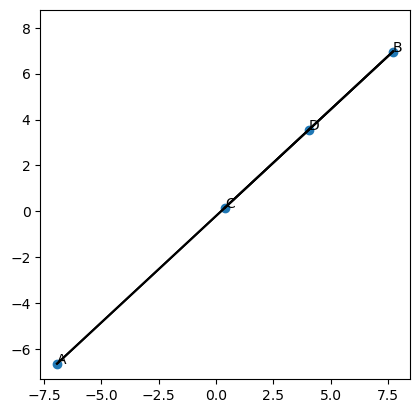

Diagram(named_points={<primitives.Point object at 0x000002209221A340>: TfPoint(x=-6.926920131296664, y=-6.643810586660009), <primitives.Point object at 0x000002209221A400>: TfPoint(x=7.7221033270001795, y=6.966063435162768), <primitives.Point object at 0x000002209221A4C0>: TfPoint(x=0.3975915978517577, y=0.16112642425137969), <primitives.Point object at 0x000002209221A580>: TfPoint(x=4.059847462425969, y=3.563594929707074)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-6.926920131296664, y=-6.643810586660009), TfPoint(x=7.7221033270001795, y=6.966063435162768)), (TfPoint(x=-6.926920131296664, y=-6.643810586660009), TfPoint(x=0.3975915978517577, y=0.16112642425137969)), (TfPoint(x=7.7221033270001795, y=6.966063435162768), TfPoint(x=0.3975915978517577, y=0.16112642425137969)), (TfPoint(x=7.7221033270001795, y=6.966063435162768), TfPoint(x=4.059847462425969, y=3.563594929707074)), (TfPoint(x=0.3975915978517577, y=0.16112642425137969), TfPoint(x=4.059847462425969, y=3.5635949297

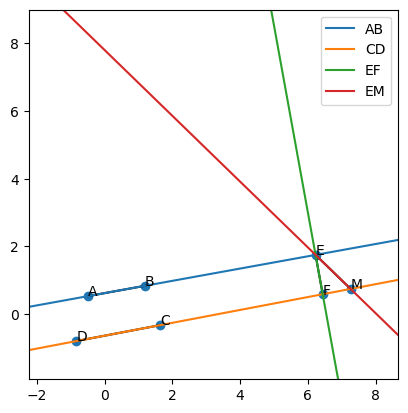

Diagram(named_points={<primitives.Point object at 0x000002209221A730>: TfPoint(x=-0.4894653512857174, y=0.5345580259798113), <primitives.Point object at 0x000002209221A7F0>: TfPoint(x=1.1916282143583121, y=0.8392192838494689), <primitives.Point object at 0x000002209221A8B0>: TfPoint(x=1.641104258460723, y=-0.3223320635076074), <primitives.Point object at 0x000002209221A970>: TfPoint(x=-0.8403606691619118, y=-0.7942024283149346), <primitives.Point object at 0x000002209221AA30>: TfPoint(x=6.440428591423846, y=0.5902977700293284), <primitives.Point object at 0x000002209221AAF0>: TfPoint(x=6.229843921531408, y=1.7522851393945054), <primitives.Point object at 0x000002209221ABB0>: TfPoint(x=7.264999937976647, y=0.7470965938919356)}, named_lines={<primitives.Line object at 0x000002209221AC70>: LineNF(n=TfPoint(x=-0.17832328854788565, y=0.9839719532392515), r=0.6132731760145886), <primitives.Line object at 0x000002209221AD60>: LineNF(n=TfPoint(x=-0.1868104376705826, y=0.9823959794183429), r=-0

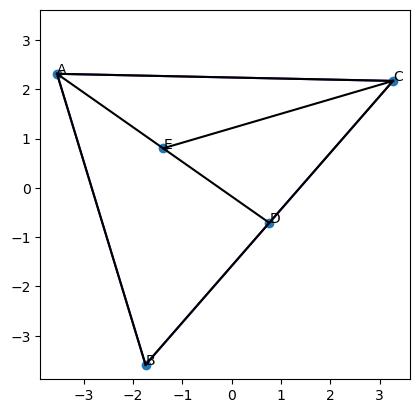

Diagram(named_points={<primitives.Point object at 0x000002209221E130>: TfPoint(x=-3.5450519347620038, y=2.315821823068212), <primitives.Point object at 0x000002209221E1F0>: TfPoint(x=-1.7489078862387901, y=-3.587766612008947), <primitives.Point object at 0x000002209221E2B0>: TfPoint(x=3.2731093799095556, y=2.171661595407584), <primitives.Point object at 0x000002209221E370>: TfPoint(x=0.7621007468353828, y=-0.7080525083006814), <primitives.Point object at 0x000002209221E430>: TfPoint(x=-1.3914755939633106, y=0.8038846573837652)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-3.5450519347620038, y=2.315821823068212), TfPoint(x=-1.7489078862387901, y=-3.587766612008947)), (TfPoint(x=-1.7489078862387901, y=-3.587766612008947), TfPoint(x=3.2731093799095556, y=2.171661595407584)), (TfPoint(x=3.2731093799095556, y=2.171661595407584), TfPoint(x=-3.5450519347620038, y=2.315821823068212)), (TfPoint(x=-3.5450519347620038, y=2.315821823068212), TfPoint(x=-1.7489078862387901, y=-3.5877666

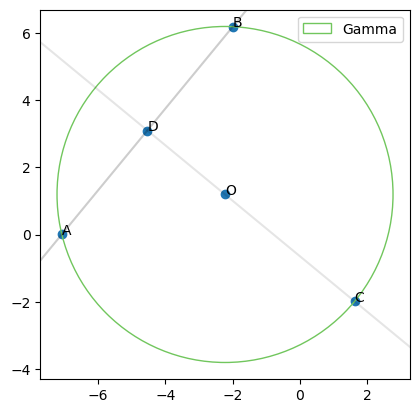

Diagram(named_points={<primitives.Point object at 0x000002209221E640>: TfPoint(x=-2.2294879492425554, y=1.1930712661937786), <primitives.Point object at 0x000002209221E6D0>: TfPoint(x=1.6243657945055934, y=-1.9847856193646594), <primitives.Point object at 0x000002209221E790>: TfPoint(x=-7.081746213068089, y=0.007089476945052908), <primitives.Point object at 0x000002209221E850>: TfPoint(x=-1.9982887122631132, y=6.182811738013221), <primitives.Point object at 0x000002209221E910>: TfPoint(x=-4.540017462665602, y=3.0949506074791358)}, named_lines={}, named_circles={<primitives.Circle object at 0x000002209221E9D0>: CircleNF(center=TfPoint(x=-2.2294879492425554, y=1.1930712661937786), radius=4.995093899346918)}, segments=[], seg_colors=[], unnamed_points=[], unnamed_lines=[LineNF(n=TfPoint(x=-0.772079380218759, y=0.6355261053969514), r=5.472175774724345), LineNF(n=TfPoint(x=0.6361956250660125, y=0.7715277873459035), r=-0.4979028452930483), LineNF(n=TfPoint(x=-0.772079380218759, y=0.635526105

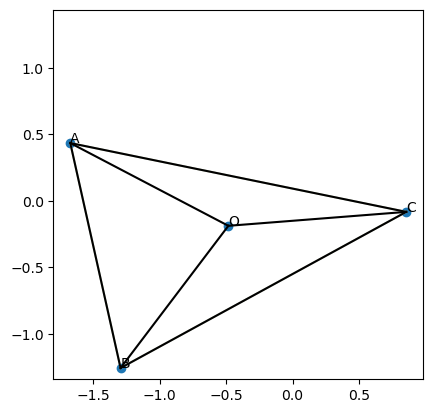

Diagram(named_points={<primitives.Point object at 0x000002209221EC70>: TfPoint(x=-1.6727131163393463, y=0.4354713185654929), <primitives.Point object at 0x000002209221ED30>: TfPoint(x=-1.2943216793082102, y=-1.2574638448649504), <primitives.Point object at 0x000002209221EDF0>: TfPoint(x=0.8554882228761551, y=-0.08253906251178367), <primitives.Point object at 0x000002209221EEB0>: TfPoint(x=-0.48316723017917107, y=-0.1874059298363334)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-1.6727131163393463, y=0.4354713185654929), TfPoint(x=-1.2943216793082102, y=-1.2574638448649504)), (TfPoint(x=-1.2943216793082102, y=-1.2574638448649504), TfPoint(x=0.8554882228761551, y=-0.08253906251178367)), (TfPoint(x=0.8554882228761551, y=-0.08253906251178367), TfPoint(x=-1.6727131163393463, y=0.4354713185654929)), (TfPoint(x=-0.48316723017917107, y=-0.1874059298363334), TfPoint(x=-1.6727131163393463, y=0.4354713185654929)), (TfPoint(x=-0.48316723017917107, y=-0.1874059298363334), TfPoint(x=-1.2

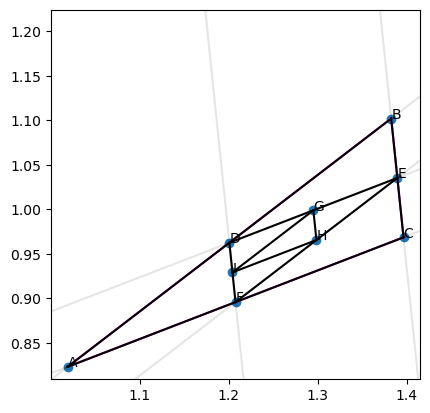

Diagram(named_points={<primitives.Point object at 0x0000022092223100>: TfPoint(x=1.0189120826781313, y=0.8230352155138777), <primitives.Point object at 0x00000220922231C0>: TfPoint(x=1.3826454752447084, y=1.1020771160890057), <primitives.Point object at 0x0000022092223280>: TfPoint(x=1.3964760135747554, y=0.9685842861652337), <primitives.Point object at 0x0000022092223340>: TfPoint(x=1.20077877896142, y=0.9625561658014417), <primitives.Point object at 0x0000022092223400>: TfPoint(x=1.389560744409732, y=1.0353307011271198), <primitives.Point object at 0x00000220922234C0>: TfPoint(x=1.2076940481264433, y=0.8958097508395557), <primitives.Point object at 0x0000022092223580>: TfPoint(x=1.295169761685576, y=0.9989434334642807), <primitives.Point object at 0x0000022092223640>: TfPoint(x=1.2986273962680877, y=0.9655702259833377), <primitives.Point object at 0x0000022092223700>: TfPoint(x=1.2042364135439316, y=0.9291829583204987)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=1.018912

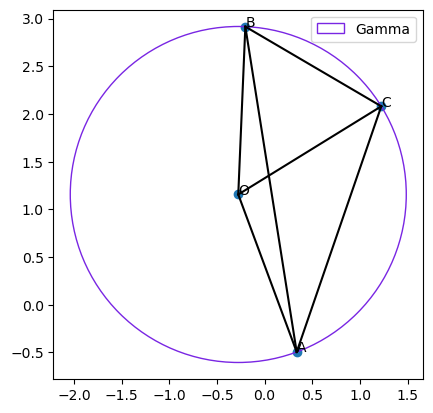

Diagram(named_points={<primitives.Point object at 0x0000022092223DC0>: TfPoint(x=-0.276741403780273, y=1.156232690657269), <primitives.Point object at 0x0000022092223E80>: TfPoint(x=0.3356586580024968, y=-0.4950808271379003), <primitives.Point object at 0x0000022092223F40>: TfPoint(x=-0.2027112249163622, y=2.915888822502913), <primitives.Point object at 0x000002209222E040>: TfPoint(x=1.2224311928003195, y=2.080544161637913)}, named_lines={}, named_circles={<primitives.Circle object at 0x000002209222E100>: CircleNF(center=TfPoint(x=-0.276741403780273, y=1.156232690657269), radius=1.761212698604174)}, segments=[(TfPoint(x=-0.276741403780273, y=1.156232690657269), TfPoint(x=0.3356586580024968, y=-0.4950808271379003)), (TfPoint(x=-0.276741403780273, y=1.156232690657269), TfPoint(x=-0.2027112249163622, y=2.915888822502913)), (TfPoint(x=-0.276741403780273, y=1.156232690657269), TfPoint(x=1.2224311928003195, y=2.080544161637913)), (TfPoint(x=0.3356586580024968, y=-0.4950808271379003), TfPoint

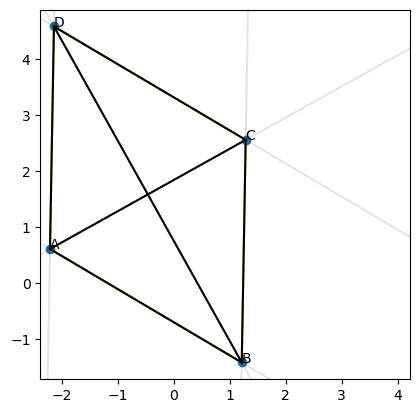

Diagram(named_points={<primitives.Point object at 0x000002209222E2E0>: TfPoint(x=-2.209477946679062, y=0.6061831032285374), <primitives.Point object at 0x000002209222E3A0>: TfPoint(x=1.2137320353391274, y=-1.4198224290365455), <primitives.Point object at 0x000002209222E460>: TfPoint(x=1.2843806271125024, y=2.5544235519958294), <primitives.Point object at 0x000002209222E520>: TfPoint(x=-2.1391706386162888, y=4.5789605460803555)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-2.209477946679062, y=0.6061831032285374), TfPoint(x=1.2137320353391274, y=-1.4198224290365455)), (TfPoint(x=1.2137320353391274, y=-1.4198224290365455), TfPoint(x=1.2843806271125024, y=2.5544235519958294)), (TfPoint(x=1.2843806271125024, y=2.5544235519958294), TfPoint(x=-2.1391706386162888, y=4.5789605460803555)), (TfPoint(x=-2.1391706386162888, y=4.5789605460803555), TfPoint(x=-2.209477946679062, y=0.6061831032285374)), (TfPoint(x=-2.209477946679062, y=0.6061831032285374), TfPoint(x=1.2137320353391274, y=-

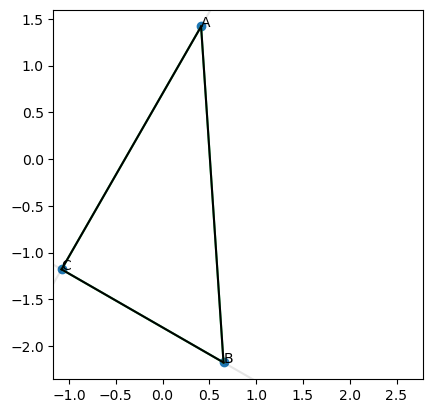

Diagram(named_points={<primitives.Point object at 0x000002209222EA60>: TfPoint(x=0.41128673533405213, y=1.4176480853845173), <primitives.Point object at 0x000002209222EB20>: TfPoint(x=0.651155490625588, y=-2.1735935510414675), <primitives.Point object at 0x000002209222EBE0>: TfPoint(x=-1.0799041846366433, y=-1.178253049921217)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=0.41128673533405213, y=1.4176480853845173), TfPoint(x=0.651155490625588, y=-2.1735935510414675)), (TfPoint(x=0.651155490625588, y=-2.1735935510414675), TfPoint(x=-1.0799041846366433, y=-1.178253049921217)), (TfPoint(x=-1.0799041846366433, y=-1.178253049921217), TfPoint(x=0.41128673533405213, y=1.4176480853845173)), (TfPoint(x=0.41128673533405213, y=1.4176480853845173), TfPoint(x=0.651155490625588, y=-2.1735935510414675)), (TfPoint(x=0.41128673533405213, y=1.4176480853845173), TfPoint(x=-1.0799041846366433, y=-1.178253049921217)), (TfPoint(x=0.651155490625588, y=-2.1735935510414675), TfPoint(x=-1.07990418463

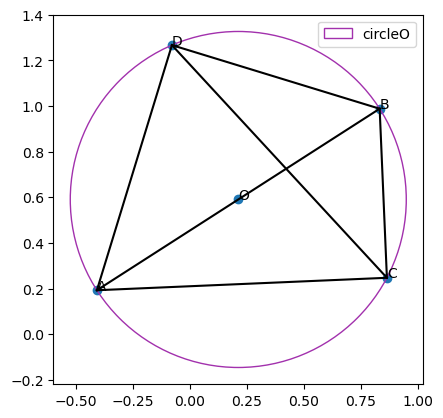

Diagram(named_points={<primitives.Point object at 0x000002209222EE80>: TfPoint(x=-0.40800899250769174, y=0.19272965501997785), <primitives.Point object at 0x000002209222EF40>: TfPoint(x=0.8315346694309863, y=0.9884076239846568), <primitives.Point object at 0x0000022092234040>: TfPoint(x=0.21176283846164728, y=0.5905686395023173), <primitives.Point object at 0x0000022092234100>: TfPoint(x=0.8633352567398314, y=0.24728105776341253), <primitives.Point object at 0x00000220922341C0>: TfPoint(x=-0.07905043267716583, y=1.2671930710495156)}, named_lines={}, named_circles={<primitives.Circle object at 0x0000022092234280>: CircleNF(center=TfPoint(x=0.21176283846164728, y=0.5905686395023173), radius=0.7364733396648014)}, segments=[(TfPoint(x=-0.40800899250769174, y=0.19272965501997785), TfPoint(x=0.8315346694309863, y=0.9884076239846568)), (TfPoint(x=-0.40800899250769174, y=0.19272965501997785), TfPoint(x=0.8633352567398314, y=0.24728105776341253)), (TfPoint(x=-0.40800899250769174, y=0.1927296550

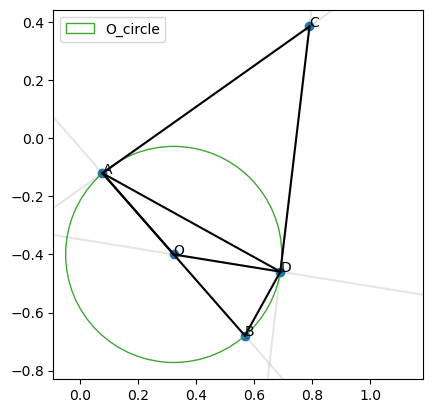

Diagram(named_points={<primitives.Point object at 0x0000022092234430>: TfPoint(x=0.07813394966381412, y=-0.12012519149978418), <primitives.Point object at 0x00000220922344F0>: TfPoint(x=0.5686800318190868, y=-0.6797942535651281), <primitives.Point object at 0x00000220922345B0>: TfPoint(x=0.32340699074145046, y=-0.39995972253245615), <primitives.Point object at 0x0000022092234670>: TfPoint(x=0.7910826325715862, y=0.38516954419557187), <primitives.Point object at 0x0000022092234730>: TfPoint(x=0.6907472631175586, y=-0.4593512516287339)}, named_lines={}, named_circles={<primitives.Circle object at 0x00000220922347F0>: CircleNF(center=TfPoint(x=0.32340699074145046, y=-0.39995972253245615), radius=0.3721105070241196)}, segments=[(TfPoint(x=0.07813394966381412, y=-0.12012519149978418), TfPoint(x=0.5686800318190868, y=-0.6797942535651281)), (TfPoint(x=0.07813394966381412, y=-0.12012519149978418), TfPoint(x=0.7910826325715862, y=0.38516954419557187)), (TfPoint(x=0.7910826325715862, y=0.3851695

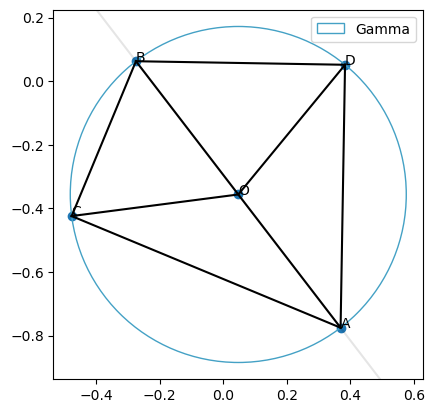

Diagram(named_points={<primitives.Point object at 0x0000022092234CA0>: TfPoint(x=0.3693151127538248, y=-0.7751241488588163), <primitives.Point object at 0x0000022092234D60>: TfPoint(x=-0.27416913843533486, y=0.06291350156687381), <primitives.Point object at 0x0000022092234E20>: TfPoint(x=0.04757298715924496, y=-0.35610532364597125), <primitives.Point object at 0x0000022092234EE0>: TfPoint(x=-0.47633875196181696, y=-0.42401158901239855), <primitives.Point object at 0x0000022092234FA0>: TfPoint(x=0.38334132843368035, y=0.05176033102807154)}, named_lines={}, named_circles={<primitives.Circle object at 0x00000220922390A0>: CircleNF(center=TfPoint(x=0.04757298715924496, y=-0.35610532364597125), radius=0.5282942090018319)}, segments=[(TfPoint(x=0.3693151127538248, y=-0.7751241488588163), TfPoint(x=-0.27416913843533486, y=0.06291350156687381)), (TfPoint(x=0.3693151127538248, y=-0.7751241488588163), TfPoint(x=-0.47633875196181696, y=-0.42401158901239855)), (TfPoint(x=-0.27416913843533486, y=0.

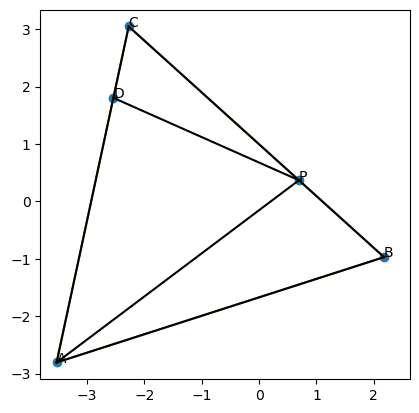

Diagram(named_points={<primitives.Point object at 0x0000022092239310>: TfPoint(x=-3.527710830581339, y=-2.8066187937176474), <primitives.Point object at 0x00000220922393D0>: TfPoint(x=2.1772596862714972, y=-0.9715378306094024), <primitives.Point object at 0x0000022092239490>: TfPoint(x=-2.2715789058844207, y=3.0470495310319152), <primitives.Point object at 0x0000022092239550>: TfPoint(x=0.6940726600643934, y=0.3682088279848924), <primitives.Point object at 0x0000022092239610>: TfPoint(x=-2.538419924832859, y=1.803550508634844)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-3.527710830581339, y=-2.8066187937176474), TfPoint(x=2.1772596862714972, y=-0.9715378306094024)), (TfPoint(x=2.1772596862714972, y=-0.9715378306094024), TfPoint(x=-2.2715789058844207, y=3.0470495310319152)), (TfPoint(x=-2.2715789058844207, y=3.0470495310319152), TfPoint(x=-3.527710830581339, y=-2.8066187937176474)), (TfPoint(x=-3.527710830581339, y=-2.8066187937176474), TfPoint(x=2.1772596862714972, y=-0.9

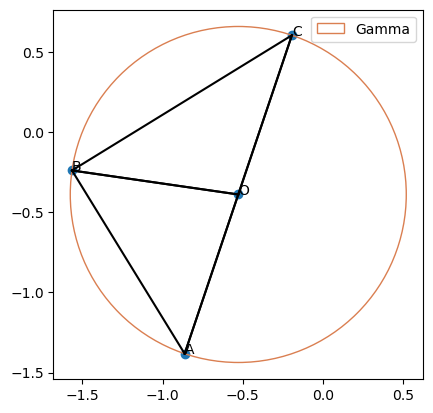

Diagram(named_points={<primitives.Point object at 0x00000220922397C0>: TfPoint(x=-0.8622981975896553, y=-1.38212489549263), <primitives.Point object at 0x0000022092239880>: TfPoint(x=-0.19354875952094358, y=0.6034122213563593), <primitives.Point object at 0x0000022092239940>: TfPoint(x=-0.5279234785552994, y=-0.3893563370681353), <primitives.Point object at 0x0000022092239A00>: TfPoint(x=-1.564733297112149, y=-0.23961902218080844)}, named_lines={}, named_circles={<primitives.Circle object at 0x0000022092239AC0>: CircleNF(center=TfPoint(x=-0.5279234785552994, y=-0.3893563370681353), radius=1.0475666390858167)}, segments=[(TfPoint(x=-0.8622981975896553, y=-1.38212489549263), TfPoint(x=-1.564733297112149, y=-0.23961902218080844)), (TfPoint(x=-0.8622981975896553, y=-1.38212489549263), TfPoint(x=-0.19354875952094358, y=0.6034122213563593)), (TfPoint(x=-1.564733297112149, y=-0.23961902218080844), TfPoint(x=-0.5279234785552994, y=-0.3893563370681353)), (TfPoint(x=-0.5279234785552994, y=-0.389

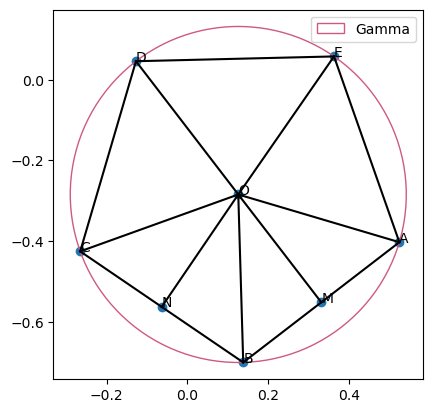

Diagram(named_points={<primitives.Point object at 0x0000022092239CA0>: TfPoint(x=0.12580404119826233, y=-0.28429950714052826), <primitives.Point object at 0x0000022092239D60>: TfPoint(x=0.5247756109340151, y=-0.40251763153558356), <primitives.Point object at 0x0000022092239E20>: TfPoint(x=0.13806125087653537, y=-0.7002365206459367), <primitives.Point object at 0x0000022092239EE0>: TfPoint(x=-0.26572600444835837, y=-0.4252181423484046), <primitives.Point object at 0x0000022092239FA0>: TfPoint(x=-0.12759712113787214, y=0.045763652451074), <primitives.Point object at 0x00000220922420A0>: TfPoint(x=0.3629549765635579, y=0.05762632143675378), <primitives.Point object at 0x0000022092242160>: TfPoint(x=0.33141843090527523, y=-0.5513770760907601), <primitives.Point object at 0x0000022092242220>: TfPoint(x=-0.0638323767859115, y=-0.5627273314971706)}, named_lines={}, named_circles={<primitives.Circle object at 0x00000220922422E0>: CircleNF(center=TfPoint(x=0.12580404119826233, y=-0.284299507140

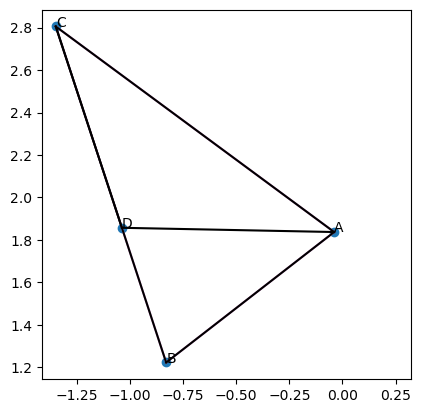

Diagram(named_points={<primitives.Point object at 0x00000220922425B0>: TfPoint(x=-0.039001341426233946, y=1.836918052992917), <primitives.Point object at 0x0000022092242670>: TfPoint(x=-0.8305126297704877, y=1.222368759122174), <primitives.Point object at 0x0000022092242730>: TfPoint(x=-1.3505308012645076, y=2.8052513631243374), <primitives.Point object at 0x00000220922427F0>: TfPoint(x=-1.0389552297299605, y=1.8568469052625454)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-0.039001341426233946, y=1.836918052992917), TfPoint(x=-0.8305126297704877, y=1.222368759122174)), (TfPoint(x=-0.8305126297704877, y=1.222368759122174), TfPoint(x=-1.3505308012645076, y=2.8052513631243374)), (TfPoint(x=-1.3505308012645076, y=2.8052513631243374), TfPoint(x=-0.039001341426233946, y=1.836918052992917)), (TfPoint(x=-0.039001341426233946, y=1.836918052992917), TfPoint(x=-0.8305126297704877, y=1.222368759122174)), (TfPoint(x=-0.8305126297704877, y=1.222368759122174), TfPoint(x=-1.35053080126450

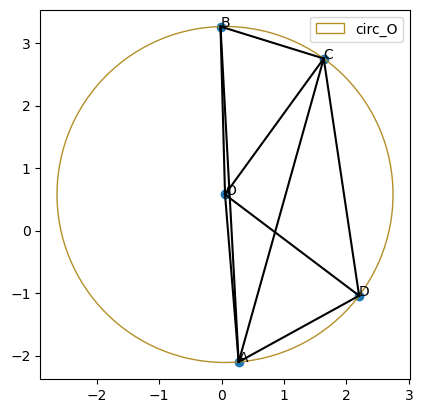

Diagram(named_points={<primitives.Point object at 0x00000220922429A0>: TfPoint(x=0.05631620902140308, y=0.576855495231523), <primitives.Point object at 0x0000022092242A60>: TfPoint(x=0.27475737833462077, y=-2.102710574174746), <primitives.Point object at 0x0000022092242B20>: TfPoint(x=-0.016046111356792417, y=3.2643365759749337), <primitives.Point object at 0x0000022092242BE0>: TfPoint(x=1.6358579704232212, y=2.7523643296773708), <primitives.Point object at 0x0000022092242CA0>: TfPoint(x=2.2021595215385283, y=-1.0427578360577134)}, named_lines={}, named_circles={<primitives.Circle object at 0x0000022092242D60>: CircleNF(center=TfPoint(x=0.05631620902140308, y=0.576855495231523), radius=2.6884551074481955)}, segments=[(TfPoint(x=0.05631620902140308, y=0.576855495231523), TfPoint(x=0.27475737833462077, y=-2.102710574174746)), (TfPoint(x=0.05631620902140308, y=0.576855495231523), TfPoint(x=-0.016046111356792417, y=3.2643365759749337)), (TfPoint(x=0.05631620902140308, y=0.576855495231523),

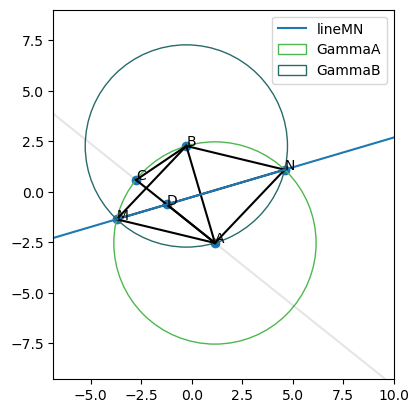

Diagram(named_points={<primitives.Point object at 0x0000022092242FA0>: TfPoint(x=1.151369300988446, y=-2.5314051503392805), <primitives.Point object at 0x00000220922470A0>: TfPoint(x=-0.2642620415057841, y=2.267761934664674), <primitives.Point object at 0x0000022092247160>: TfPoint(x=-2.7504523830509484, y=0.5863752683431591), <primitives.Point object at 0x0000022092247220>: TfPoint(x=-3.7126469828782063, y=-1.3577943128307757), <primitives.Point object at 0x00000220922472E0>: TfPoint(x=4.599754242360868, y=1.094151097156169), <primitives.Point object at 0x00000220922473A0>: TfPoint(x=-1.2328123188664775, y=-0.6263066166536466)}, named_lines={<primitives.Line object at 0x0000022092247460>: LineNF(n=TfPoint(x=-0.2829225425122353, y=0.9591427604576975), r=-0.2519270614959912)}, named_circles={<primitives.Circle object at 0x0000022092247550>: CircleNF(center=TfPoint(x=1.151369300988446, y=-2.5314051503392805), radius=5.003600384486892), <primitives.Circle object at 0x00000220922475E0>: Ci

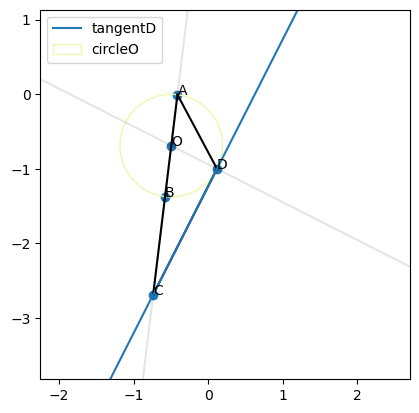

Diagram(named_points={<primitives.Point object at 0x00000220922478B0>: TfPoint(x=-0.4128653173378354, y=-0.006777651827323971), <primitives.Point object at 0x0000022092247970>: TfPoint(x=-0.5788293728762128, y=-1.3720263578657208), <primitives.Point object at 0x0000022092247A30>: TfPoint(x=-0.4958473451070241, y=-0.6894020048465224), <primitives.Point object at 0x0000022092247AF0>: TfPoint(x=0.11733542945372122, y=-1.0006397102254687), <primitives.Point object at 0x0000022092247BB0>: TfPoint(x=-0.7387003846914808, y=-2.6871526441318005)}, named_lines={<primitives.Line object at 0x0000022092247C70>: LineNF(n=TfPoint(x=-0.8917081329187215, y=0.45261087667731514), r=-0.5575293732066782)}, named_circles={<primitives.Circle object at 0x0000022092247D60>: CircleNF(center=TfPoint(x=-0.4958473451070241, y=-0.6894020048465224), radius=0.6876496377280844)}, segments=[(TfPoint(x=-0.4128653173378354, y=-0.006777651827323971), TfPoint(x=-0.5788293728762128, y=-1.3720263578657208)), (TfPoint(x=-0.73

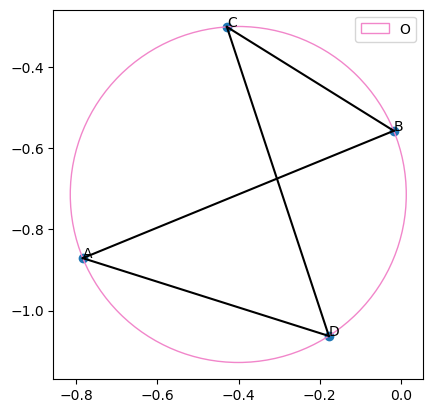

Diagram(named_points={<primitives.Point object at 0x000002209224D100>: TfPoint(x=-0.7840165313533735, y=-0.8707077592062373), <primitives.Point object at 0x000002209224D190>: TfPoint(x=-0.017355401920087173, y=-0.5567409348645356), <primitives.Point object at 0x000002209224D250>: TfPoint(x=-0.42880318404678297, y=-0.30045018182795463), <primitives.Point object at 0x000002209224D310>: TfPoint(x=-0.1773338947589352, y=-1.0625795684821637)}, named_lines={}, named_circles={<primitives.Circle object at 0x000002209224D3D0>: CircleNF(center=TfPoint(x=-0.40068596663673034, y=-0.7137243470353865), radius=0.41422954209325025)}, segments=[(TfPoint(x=-0.7840165313533735, y=-0.8707077592062373), TfPoint(x=-0.017355401920087173, y=-0.5567409348645356)), (TfPoint(x=-0.017355401920087173, y=-0.5567409348645356), TfPoint(x=-0.42880318404678297, y=-0.30045018182795463)), (TfPoint(x=-0.7840165313533735, y=-0.8707077592062373), TfPoint(x=-0.1773338947589352, y=-1.0625795684821637)), (TfPoint(x=-0.17733389

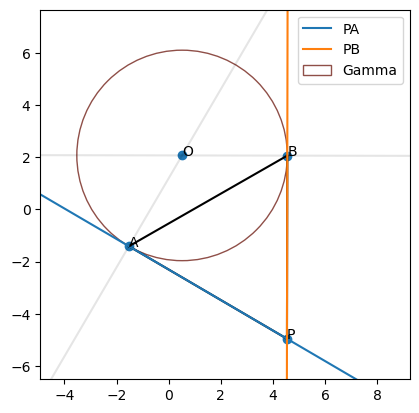

Diagram(named_points={<primitives.Point object at 0x000002209224D580>: TfPoint(x=0.5135603108971868, y=2.0715831750299545), <primitives.Point object at 0x000002209224D640>: TfPoint(x=-1.5249467135800914, y=-1.4110854710024119), <primitives.Point object at 0x000002209224D700>: TfPoint(x=4.5489582996469595, y=2.0641764689865085), <primitives.Point object at 0x000002209224D7C0>: TfPoint(x=4.5360681398565665, y=-4.95877335347371)}, named_lines={<primitives.Line object at 0x000002209224D880>: LineNF(n=TfPoint(x=0.5051555253013718, y=0.8630283281894605), r=-1.9881419931268005), <primitives.Line object at 0x000002209224D970>: LineNF(n=TfPoint(x=-0.9999983155955576, y=0.0018354307526058378), r=-4.545161984391409)}, named_circles={<primitives.Circle object at 0x000002209224DA60>: CircleNF(center=TfPoint(x=0.5135603108971868, y=2.0715831750299545), radius=4.035404786003521)}, segments=[(TfPoint(x=4.5360681398565665, y=-4.95877335347371), TfPoint(x=-1.5249467135800914, y=-1.4110854710024119)), (T

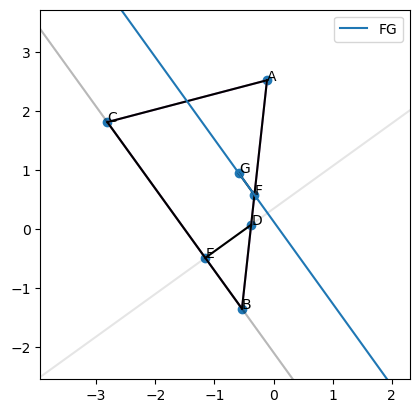

Diagram(named_points={<primitives.Point object at 0x000002209224DD30>: TfPoint(x=-0.5343313264870894, y=-1.3454016617690472), <primitives.Point object at 0x000002209224DDF0>: TfPoint(x=-0.11113039960580268, y=2.5193051240191418), <primitives.Point object at 0x000002209224DEB0>: TfPoint(x=-2.811552047230919, y=1.8110845297979887), <primitives.Point object at 0x000002209224DF70>: TfPoint(x=-0.3789093016656989, y=0.07392546119980481), <primitives.Point object at 0x0000022092253070>: TfPoint(x=-1.154575700674121, y=-0.48567261368669384), <primitives.Point object at 0x0000022092253130>: TfPoint(x=-0.3234904035598122, y=0.5800155426868057), <primitives.Point object at 0x00000220922531F0>: TfPoint(x=-0.587923594997906, y=0.9473848681433612)}, named_lines={<primitives.Line object at 0x00000220922532B0>: LineNF(n=TfPoint(x=0.8116105182796852, y=0.5841989101477174), r=0.07629623381468503)}, named_circles={}, segments=[(TfPoint(x=-0.5343313264870894, y=-1.3454016617690472), TfPoint(x=-0.111130399

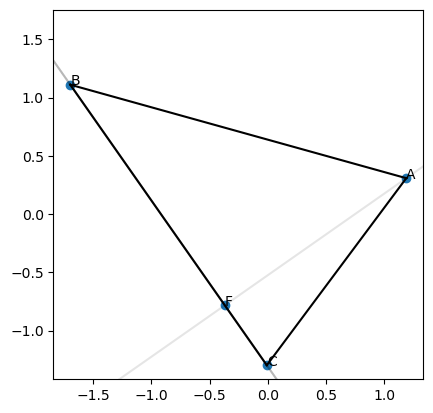

Diagram(named_points={<primitives.Point object at 0x00000220922536D0>: TfPoint(x=1.1891530726541826, y=0.3082477827902333), <primitives.Point object at 0x0000022092253790>: TfPoint(x=-1.6960659538897556, y=1.110995723670317), <primitives.Point object at 0x0000022092253850>: TfPoint(x=-0.008359969026763035, y=-1.2980308742403366), <primitives.Point object at 0x0000022092253910>: TfPoint(x=-0.36895189453651056, y=-0.7833230120084456)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=1.1891530726541826, y=0.3082477827902333), TfPoint(x=-1.6960659538897556, y=1.110995723670317)), (TfPoint(x=1.1891530726541826, y=0.3082477827902333), TfPoint(x=-0.008359969026763035, y=-1.2980308742403366)), (TfPoint(x=-1.6960659538897556, y=1.110995723670317), TfPoint(x=-0.008359969026763035, y=-1.2980308742403366))], seg_colors=[[0, 0, 0], [0, 0, 0], [0, 0, 0]], unnamed_points=[], unnamed_lines=[LineNF(n=TfPoint(x=0.8190102690960206, y=0.5737788590696453), r=-0.7516295745410381), LineNF(n=TfPoint(x=

In [1]:
import pickle

with open('../llm_gen/res_all_in_one_dict_20250311160543.pkl', 'rb') as f:
    gmb_result_dict = pickle.load(f)

for key, res in gmb_result_dict.items():
    print(res[2])
    print(res[0])
    if res[1] == []:
        print('Fail to solve!!!')
    elif res[1][0] is None:
        print('GMBL grammar error!!!')
    else:
        res[1][0].plot()
        print(res[1][0])
    # print(res[3])
    # print(res[4])
    
    print('')
    

In [2]:
from llm_generator import *

cnt = -1
input_captions = []
with open("C:\qinshenghao\桌面\geoqa_v2_99k_20250103.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        cnt += 1
        data = json.loads(line)
        if cnt == 160:
            break
        if cnt % 20 != 0:
            continue

        content = data['conversations'][1]['value']
        #print(data['conversations'][0]['value'])
        #print(data['conversations'][1]['value'])
        # inds = []
        # re_find = re.finditer('Information in the Image', content)
        # for ind in re_find:
        #     inds += [ind.span()]
        # re_find = re.finditer('Terms and Knowledge Points', content)
        # for ind in re_find:
        #     inds += [ind.span()]

        # inds = []
        # re_find = re.finditer('<image>\n', content)
        # for ind in re_find:
        #     inds += [ind.span()]
        # re_find = re.finditer('\nA', content)
        # for ind in re_find:
        #     inds += [ind.span()]

        
        inds = []
        re_find = re.finditer('## 列出已知信息', content)
        for ind in re_find:
            inds += [ind.span()]
        re_find = re.finditer('## 术语与知识点', content)
        for ind in re_find:
            inds += [ind.span()]

        lines = content[inds[0][1] : inds[1][0]]
        lines = ''.join(lines.splitlines()[:-1])
        lines = ''.join(['\n', lines, '\n'])

        input_captions += [lines]

filename = '..\grammar_example.txt'
with open(filename, 'r', encoding='utf-8') as file:
    grammer_example = [line for line in file]
grammer_example = ''.join(grammer_example)

quest1 = '根据文档中的GMBL的语法和示例，使用GMBL语法，生成如下几何题对应的代码。'
quest2 = '请确保每个点在使用前都已经定义过，确保没有重复定义点或者图形，确保符合示例的GMBL语法，确保每一句语句都写在同一行，确保GMBL输入的角度是弧度制，确保没有形如(define XXX number xxx)或(param XXX number xxx)的语句，确保语句中没有使用and或者or。'
quest3 = '把最终回答放在代码block内。最后列出所有需要连接的线段，以";; segments to connect: AB AC BC"的形式罗列。'

messages_list = [
    [[{
    "role": "user", 
    "content": grammer_example + '\n\n' + quest1 + input_caption + quest2 + quest3
    }], input_caption]
    for input_caption in input_captions]

messages_list

[[[{'role': 'user',
    'content': '以下内容是GMBL语法下define函数能够使用的function,第一列是function名称及形式,第二列是define出来的类型,第三列是这个function的含义。完整语句的形式为(define XXX OBJECT_TYPE (function ...))。\n(amidp-opp A B C),点,弧AB(不包含C)的中点\n(amidp-same A B C),点,弧ACB的中点\n(centroid A B C),点,三角形ABC的重心\n(circumcenter A B C),点,三角形ABC的外心\n(excenter A B C),点,三角形ABC中角A对应的旁心\n(foot A L1),点,点A到直线L1的垂足\n(incenter A B C),点,三角形ABC的内心\n(inter-cc C1 C2 <root-selector>),点,圆C1和圆C2的交点\n(inter-ll L1 L2),点,直线L1和直线L2的交点\n(inter-lc L1 C1 <root-selector>),点,直线L1和圆C1的交点\n(midp A B),点,线段AB的中点\n(orthocenter A B C),点,三角形ABC的垂心\n(line A B),线,直线AB\n(perp-bis A B),线,线段AB的垂直平分线\n(perp-at A L1),线,过点A且垂直与直线L1的直线\n(reflect-ll L1 L2),线,线L1关于L2的对称线\n(circ A B C),圆,过点A、点B、点C的圆\n(circumcircle A B C),圆,三角形ABC的外接圆\n(excircle A B C),圆,三角形ABC的角A对应的旁切圆\n(incircle A B C),圆,三角形ABC的内切圆\n(diam A B),圆,以线段AB为直径的圆\n(coa A B),圆,以点A为圆心且经过点B的圆\n(add N1 N2),数,N1加N2\n(area A B C),数,三角形ABC的面积\n(dist A B),数,线段AB的长度\n(div N1 N2),数,N1除以N2\n(mul N1 N2),数,N1乘以N2\npi,数,圆周率数值\n(pow

In [ ]:
res = try_generate_and_draw(messages_list[1])

----- standard request -----

### 问题文本中的信息1. AB = 42. BC = 53. AC的垂直平分线交AD于点E### 图片中的信息图片显示一个平行四边形ABCD，且有以下特征：1. 点A, B, C, D按顺时针方向依次排列。2. AB为底边，长度为4。3. BC为侧边，长度为5。4. 线段AC被垂直平分，且中垂线与AD交于点E。图片还给我们一些几何关系的提示：1. E是AC的中垂线上一点，所以AE=EC。2. AC的中垂线意味着BE=DE，这是一个几何性质，并且DE垂直于AC。

